In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import NMF
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import (
    silhouette_score,
    davies_bouldin_score,
    calinski_harabasz_score,
    pairwise_distances_argmin_min
)

from tqdm.notebook import tqdm
from scipy.ndimage import gaussian_filter1d


In [12]:
# ==== Importar matriz W do NMF (para clustering) ====
import pandas as pd

# ==== 0) Parâmetros ====
ARQ_IN    = "Matrix.csv"        # saída do passo anterior (pivot pronto)
OUT_W     = "W_frames.csv"      # pesos por frame (frames × K)
OUT_H     = "H_padroes.csv"     # padrões (K × células)
OUT_TOP   = "frames_tipicos_TS.csv"
SEED      = 42
MAX_ITER  = 2000

# Ler a matriz guardada anteriormente
df_W = pd.read_csv("nmf_W_TS.csv", index_col=0)

print(f"✅ df_W carregado: {df_W.shape[0]} frames × {df_W.shape[1]} padrões")


✅ df_W carregado: 850 frames × 16 padrões


Cotovelo pela inércia (queda < 5%): 3
Cotovelo por consenso de métricas: 19

➡️ Nº de clusters escolhido: 19


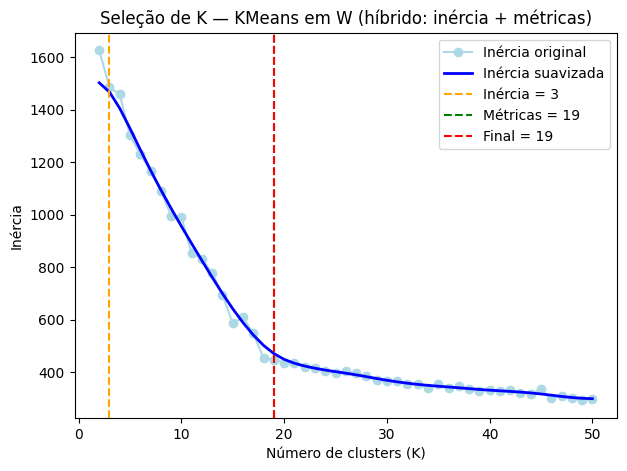

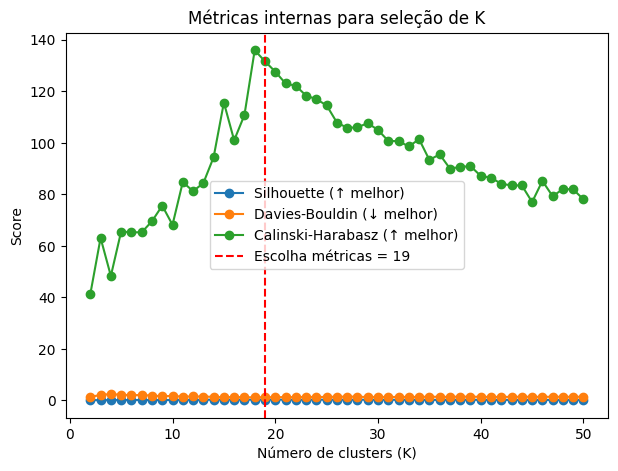

In [13]:
import numpy as np
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d

# ==== Clustering em W com KMeans ====

max_k = min(50, df_W.shape[0])
Ks, inertias = [], []
sil_scores, db_scores, ch_scores = [], [], []

for k in range(2, max_k+1):
    km = MiniBatchKMeans(n_clusters=k, random_state=SEED, batch_size=128, n_init=10)
    labels = km.fit_predict(df_W.values)
    
    Ks.append(k)
    inertias.append(km.inertia_)
    
    # Métricas internas
    sil_scores.append(silhouette_score(df_W.values, labels))
    db_scores.append(davies_bouldin_score(df_W.values, labels))
    ch_scores.append(calinski_harabasz_score(df_W.values, labels))

# Arrays
inertias = np.array(inertias)
sil_scores = np.array(sil_scores)
db_scores = np.array(db_scores)
ch_scores = np.array(ch_scores)

# Suavizar curva da inércia
inertias_smooth = gaussian_filter1d(inertias, sigma=2)

# === Critério do cotovelo (queda relativa na curva suavizada) ===
drops = np.r_[np.nan, -(np.diff(inertias_smooth))]
rel = drops / np.r_[np.nan, inertias_smooth[:-1]]
limite = 0.05  # 5%
idx = np.where(rel < limite)[0]
K_cotovelo_inercia = Ks[idx[0]] if len(idx) else Ks[np.argmin(inertias_smooth)]

# === Critério por consenso de métricas ===
# Normalizar para 0–1
sil_norm = (sil_scores - np.min(sil_scores)) / (np.max(sil_scores) - np.min(sil_scores))
db_norm  = 1 - (db_scores - np.min(db_scores)) / (np.max(db_scores) - np.min(db_scores))  # invertido
ch_norm  = (ch_scores - np.min(ch_scores)) / (np.max(ch_scores) - np.min(ch_scores))

final_score = sil_norm + db_norm + ch_norm
K_cotovelo_metricas = Ks[np.argmax(final_score)]

# === Resultado final ===
print(f"Cotovelo pela inércia (queda < {limite*100:.0f}%): {K_cotovelo_inercia}")
print(f"Cotovelo por consenso de métricas: {K_cotovelo_metricas}")

# Escolha final (podes trocar por consenso, média, etc.)
K_cotovelo = K_cotovelo_metricas
print(f"\n➡️ Nº de clusters escolhido: {K_cotovelo}")

# === Gráfico da inércia ===
plt.figure(figsize=(7,5))
plt.plot(Ks, inertias, marker="o", color="lightblue", label="Inércia original")
plt.plot(Ks, inertias_smooth, color="blue", linewidth=2, label="Inércia suavizada")
plt.axvline(K_cotovelo_inercia, color="orange", linestyle="--", label=f"Inércia = {K_cotovelo_inercia}")
plt.axvline(K_cotovelo_metricas, color="green", linestyle="--", label=f"Métricas = {K_cotovelo_metricas}")
plt.axvline(K_cotovelo, color="red", linestyle="--", label=f"Final = {K_cotovelo}")
plt.xlabel("Número de clusters (K)")
plt.ylabel("Inércia")
plt.title("Seleção de K — KMeans em W (híbrido: inércia + métricas)")
plt.legend()
plt.grid(False)
plt.show()

# === Gráfico das métricas internas ===
plt.figure(figsize=(7,5))
plt.plot(Ks, sil_scores, marker="o", label="Silhouette (↑ melhor)")
plt.plot(Ks, db_scores, marker="o", label="Davies-Bouldin (↓ melhor)")
plt.plot(Ks, ch_scores, marker="o", label="Calinski-Harabasz (↑ melhor)")
plt.axvline(K_cotovelo_metricas, color="red", linestyle="--", label=f"Escolha métricas = {K_cotovelo_metricas}")
plt.xlabel("Número de clusters (K)")
plt.ylabel("Score")
plt.title("Métricas internas para seleção de K")
plt.legend()
plt.grid(False)
plt.show()


In [14]:
# ==== Aplicar K-Means final em W (usando K do cotovelo) ====
kmeans = MiniBatchKMeans(
    n_clusters=K_cotovelo,
    random_state=SEED,
    batch_size=128,
    n_init=10
)
labels = kmeans.fit_predict(df_W.values)

df_clusters = df_W.copy()
df_clusters["cluster"] = labels
df_clusters["timestamp"] = df_W.index

print("Clusters atribuídos (primeiras linhas):")
display(df_clusters.head())

print("\nDistribuição por cluster:")
print(df_clusters["cluster"].value_counts())


Clusters atribuídos (primeiras linhas):


,padrao_1,padrao_2,padrao_3,padrao_4,padrao_5,padrao_6,padrao_7,padrao_8,padrao_9,padrao_10,padrao_11,padrao_12,padrao_13,padrao_14,padrao_15,padrao_16,cluster,timestamp
timestamp,,,,,,,,,,,,,,,,,,
1900-01-01 00:00:00.852,0.000000,0.000000e+00,9.431295e-155,4.226021e-83,1.195915e-46,0.000000,4.593524e-101,4.508182e-78,2.806507e-59,1.863434e+00,1.012762e+00,1.009208e-81,1.281967e-36,3.629010e-117,1.750227e-20,0.00000,7,1900-01-01 00:00:00.852
1900-01-01 00:00:03.401,0.262673,0.000000e+00,5.756467e-252,1.953594e-82,5.694325e-19,0.599497,2.788895e-51,2.802952e-20,3.734614e-61,1.502444e-220,5.382139e-69,0.000000e+00,2.958861e-01,2.446862e-78,1.687845e+00,0.00000,14,1900-01-01 00:00:03.401
1900-01-01 00:00:07.974,0.000000,0.000000e+00,1.308255e+00,0.000000e+00,1.138317e-271,0.000000,4.752867e-57,3.591706e-76,0.000000e+00,2.669327e-01,4.382321e-115,0.000000e+00,1.575743e-82,1.414540e-143,0.000000e+00,0.00000,3,1900-01-01 00:00:07.974
1900-01-01 00:00:08.614,0.000000,1.649873e-47,0.000000e+00,6.107327e-01,0.000000e+00,0.002216,0.000000e+00,1.455044e-79,2.497476e-01,0.000000e+00,0.000000e+00,4.036409e-01,2.688885e-23,2.562473e-01,0.000000e+00,0.74553,8,1900-01-01 00:00:08.614
1900-01-01 00:00:09.458,0.000000,0.000000e+00,1.468883e+00,6.498513e-184,9.167106e-90,0.000000,1.319310e-48,0.000000e+00,0.000000e+00,5.520660e-58,0.000000e+00,1.458454e-129,0.000000e+00,0.000000e+00,3.110900e-14,0.00000,3,1900-01-01 00:00:09.458



Distribuição por cluster:
cluster
1     147
3      91
16     83
6      44
17     43
8      41
0      39
11     38
4      36
7      35
14     35
9      35
12     32
5      31
2      30
18     27
10     26
15     23
13     14
Name: count, dtype: int64


In [15]:
# ==== Selecionar frames típicos (medoids) ====

# índices dos medoids
closest, _ = pairwise_distances_argmin_min(kmeans.cluster_centers_, df_W.values)

# marcar medoids
df_clusters["is_medoid"] = False
df_clusters.iloc[closest, df_clusters.columns.get_loc("is_medoid")] = True

# mostrar resultados
medoids = df_clusters[df_clusters["is_medoid"]][["timestamp", "cluster"]]
print("Timestamps mais representativos (medoids):")
display(medoids)


Timestamps mais representativos (medoids):


,timestamp,cluster
timestamp,,
1900-01-01 00:02:57.566,1900-01-01 00:02:57.566,3
1900-01-01 00:07:43.363,1900-01-01 00:07:43.363,7
1900-01-01 00:09:01.699,1900-01-01 00:09:01.699,14
1900-01-01 00:11:11.236,1900-01-01 00:11:11.236,17
1900-01-01 00:18:08.062,1900-01-01 00:18:08.062,4
1900-01-01 00:20:27.157,1900-01-01 00:20:27.157,15
1900-01-01 00:21:19.227,1900-01-01 00:21:19.227,6
1900-01-01 00:25:33.558,1900-01-01 00:25:33.558,12
1900-01-01 00:27:20.550,1900-01-01 00:27:20.550,16


In [16]:
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

# ==== Métricas de clusterização (validação opcional) ====
X_features = df_W.values  

labels = df_clusters["cluster"].values  
silhouette = silhouette_score(X_features, labels)        # varia de -1 a 1; >0.3 já indica clusters razoáveis
davies     = davies_bouldin_score(X_features, labels)   # quanto menor, melhor; valores próximos de 1 são bons
calinski   = calinski_harabasz_score(X_features, labels) # quanto maior, melhor; valores altos indicam boa separação


print("📊 Métricas de clusterização (KMeans em W)")
print(f"Silhouette Score:        {silhouette:.4f}")
print(f"Davies-Bouldin Index:    {davies:.4f}")
print(f"Calinski-Harabasz Index: {calinski:.4f}")



📊 Métricas de clusterização (KMeans em W)
Silhouette Score:        0.3277
Davies-Bouldin Index:    1.2766
Calinski-Harabasz Index: 131.6606


In [17]:
# ==== Exportar frames típicos (medoids) ====
medoids = df_clusters.loc[df_clusters["is_medoid"], ["timestamp", "cluster"]]

medoids.to_csv(OUT_TOP, index=False)

print("Frames típicos (medoids) exportados para:", OUT_TOP)
display(medoids)


Frames típicos (medoids) exportados para: frames_tipicos_TS.csv


,timestamp,cluster
timestamp,,
1900-01-01 00:02:57.566,1900-01-01 00:02:57.566,3
1900-01-01 00:07:43.363,1900-01-01 00:07:43.363,7
1900-01-01 00:09:01.699,1900-01-01 00:09:01.699,14
1900-01-01 00:11:11.236,1900-01-01 00:11:11.236,17
1900-01-01 00:18:08.062,1900-01-01 00:18:08.062,4
1900-01-01 00:20:27.157,1900-01-01 00:20:27.157,15
1900-01-01 00:21:19.227,1900-01-01 00:21:19.227,6
1900-01-01 00:25:33.558,1900-01-01 00:25:33.558,12
1900-01-01 00:27:20.550,1900-01-01 00:27:20.550,16
